Author: Akshay Chougule

Creation Date: 09-Feb-2020

Description: This is a v4 of notebook for Human-Protein-Atlas-Competition.

Change log: The changes made wrt to the v3.5

- We try to implement focal loss

Possible thing to try next
- Try diffrent model architecture (DenseNet?)
- Move things to Jovian
- Images w/o y
- 512*512 (first train on smaller images)
- 4-channel resnet, your own resnet block
- Less frequent categories: 1. Ignore less frq cats 2. A research paper, SMOTE

In [1]:
# To deal with the  PILLOW_VERSION error. Downgrade the library
#!pip3 install Pillow==5.1

In [1]:
!pip3 show Pillow

Name: Pillow
Version: 6.1.0
Summary: Python Imaging Library (Fork)
Home-page: http://python-pillow.org
Author: Alex Clark (Fork Author)
Author-email: aclark@aclark.net
License: UNKNOWN
Location: /home/ubuntu/.local/lib/python3.6/site-packages
Requires: 


In [2]:
import pandas as pd
import wget
import time
import os
import copy

In [3]:
import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [4]:
import fastai
from fastai.vision.image import *
from fastai.vision import *
from fastai.metrics import *
from fastai.vision import *

In [5]:
data_root = '/home/ubuntu/datasets/human-protein-atlas/'

In [6]:
train_labels = pd.read_csv(os.path.join(data_root,'train.csv'))
train_labels.head(5)

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


__Create the databunch__

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
additional_aug=[*zoom_crop(scale=(0.75,1.25), do_rand=False), 
#                     brightness(scale=(0.4, 0.6)), 
#                     contrast(scale=(0.6, 1.4), p=0.75)
                   ]
#tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
tfms = get_transforms(dihedral_affine(),max_lighting=0.2, max_zoom=1.15, xtra_tfms=additional_aug)

In [9]:
test = ImageList.from_csv(data_root,'sample_submission.csv',folder='test_512by512',suffix='.png')

In [10]:
src = (ImageList.from_csv(data_root,'train.csv',folder='train_512by512',suffix='.png')
        .split_by_rand_pct(0.2)
        .label_from_df(cols='Target',label_delim=' ')
       .add_test(test))

In [11]:
src.train.databunch

<bound method LabelList.databunch of LabelList (24858 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
16;0,7;1;2;0,5,1,18
Path: /home/ubuntu/datasets/human-protein-atlas>

In [12]:
src.valid.databunch

<bound method LabelList.databunch of LabelList (6214 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
5,7;0,25;0,23,7;0
Path: /home/ubuntu/datasets/human-protein-atlas>

In [13]:
src.test.databunch

<bound method LabelList.databunch of LabelList (11702 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: EmptyLabelList
,,,,
Path: /home/ubuntu/datasets/human-protein-atlas>

^ that looks correct. We have 80% of the images in train and 20% in validation databunch as specified. Alos the test data count match.

In [56]:
data = (src.transform(tfms, size=224)
        .databunch(bs = 8).normalize(imagenet_stats))

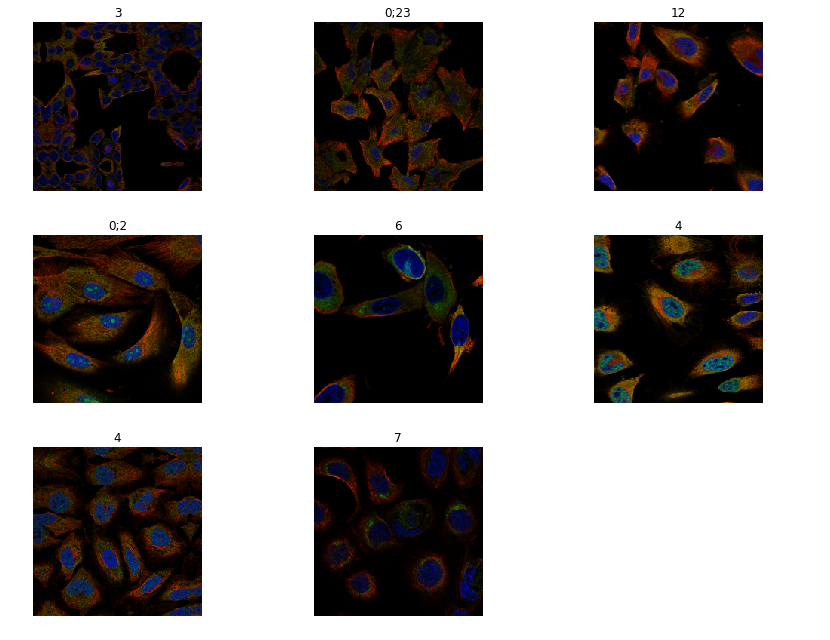

In [57]:
data.show_batch(rows=3, figsize=(12,9))

In [23]:
# method 1: from kornia  // Did NOT work. Seems for single class classification
# from kornia.losses import focal
# FC = focal.FocalLoss(alpha= 0.5, gamma=2.0)

In [93]:
# method 2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)
        print(len(target))
        logpt = F.log_softmax(input)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [61]:
# Method 3: From kaggle:https://www.kaggle.com/c/tgs-salt-identification-challenge/discussion/65938
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets.long() , reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets.long() , reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [147]:
# method 4 : https://colab.research.google.com/drive/1NiUwI6ohF1b9TthutyfJQnOJ2i39R5cJ#scrollTo=qo8kiV3mtC-S

def focal_loss(y_pred,y_true,alpha=0.25,gamma=2,):
    
    if isinstance(alpha,(list,tuple)):
        fore_alpha = alpha[0] # postive sample ratio in the entire dataset
        back_alpha = alpha[1] #(1-alpha) # negative ratio in the entire dataset
    elif isinstance(alpha ,(int,float)):
        fore_alpha = alpha
        back_alpha = (1-alpha)
        
    n_positives = (y_true!=0).sum() # all postive anchors for 20 class
  
    y_true = torch.eye(y_pred.shape[-1])[int(y_true)].cuda() # one hot vector for all prediction
    y_pred = F.softmax(y_pred,dim=1) # apply softmax
    
    # in the dataset background classes is taken in the front so 1 background class + 20 classes = 21 classes
    back_pred = y_pred[:,0:1] # 1st column background
    fore_pred = y_pred[:,1:]  # 20 columns foreground
    back_true = y_true[:,0:1]  # 1st column background
    fore_true = y_true[:,1:] # 20 columns foreground
    
    alpha_factor = torch.cat([ back_true *back_alpha ,  fore_true * fore_alpha],dim=1)  ## alpha factor 
    
    focal_weight = torch.cat([ back_true * back_pred , fore_true * (1-fore_pred) ] ,dim=1) #because background is also a class so (1-back_true) will lead to false output
    
    cross_entropy = -1 *  torch.log(y_pred) # normal cross entropy
    loss =  alpha_factor * (focal_weight ** gamma) * cross_entropy # focal loss with modulating factor
    
    # normalize the loss with positive anchors
    return loss.sum()/n_positives  # if want to use it for anything else other then SSD use loss = loss.sum()/len(y_pred)

In [155]:
# method 5: the creator's code
# source: https://github.com/kuangliu/pytorch-retinanet/blob/master/loss.py
# did a wget and renamed as focal_loss
import focal_loss

ValueError: not enough values to unpack (expected 2, got 0)

In [148]:
arch = models.resnet18
#FC = FocalLoss()
fc = partial(focal_loss, gamma=2.0, alpha=0.25)
#f1-macro = partial(MultiLabelFbeta, beta=2, average="macro")

In [120]:
setattr(src, 'device', 'cuda') 
#setattr(FocalLoss, 'func', 'NA') 

In [121]:
# to get the v3.5 results w resnet 34
#learn.load('nb-v3-resnet34-stage2-F1-macro')

In [149]:
learn = cnn_learner(data, arch)

In [150]:
learn.loss_func=fc
# learn.loss_func=FocalLoss(alpha= 0.5, gamma=2.0)
# learn.loss_func=focal.FocalLoss(alpha= 0.5, gamma=2.0)

In [135]:
learn.data.batch_size

8

In [136]:
learn.lr_find()

epoch,train_loss,valid_loss,focal_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


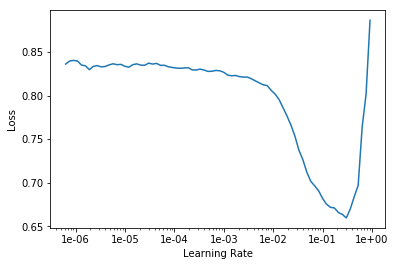

In [126]:
learn.recorder.plot()

In [137]:
lr = 0.01

In [151]:
# I belive this was run after stage 1 (5 epochs) and stage 2 (10 epochs), model save, model load, then these 5 epochs.
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time


ValueError: only one element tensors can be converted to Python scalars

In [24]:
learn.save('nb-v3-resnet34-stage1-F1-macro')

In [25]:
learn.unfreeze()

epoch,train_loss,valid_loss,multi_label_fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


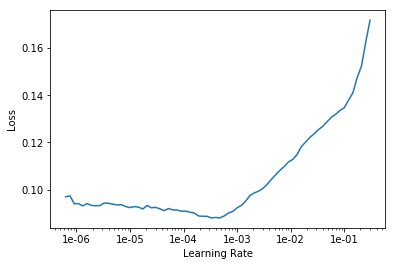

In [26]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(10, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,multi_label_fbeta,time
0,0.090062,0.083211,0.490106,03:30
1,0.091978,0.086438,0.477226,03:32
2,0.089508,0.091704,0.445601,03:32
3,0.088943,0.091707,0.435489,03:32
4,0.087743,0.086021,0.519227,03:31
5,0.084480,0.082603,0.513390,03:33
6,0.079264,0.082319,0.536157,03:35
7,0.078128,0.081767,0.525784,03:36
8,0.074349,0.080644,0.538895,03:35
9,0.073889,0.080873,0.529944,03:34


In [38]:
learn.save('nb-v3.5-resnet34-stage2-F1-macro')

In [30]:
# This was saved at the end of v3. What we see above is v3.5
# learn.save('nb-v3-resnet34-stage2-F1-macro')

In [23]:
#learn.load('nb-v3-resnet34-stage2-F1-macro')

### Testing the data

__Making the predictions__

In [29]:
preds, _ = learn.get_preds(DatasetType.Test)

fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512/','')
sample_submission = pd.read_csv(data_root+'sample_submission.csv')

In [27]:
learn.data.test_ds.items

array(['/home/ubuntu/datasets/human-protein-atlas/test_512by512/00008af0-bad0-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0000a892-bacf-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/0008baca-bad7-11e8-b2b9-ac1f6b6435d0.png', ...,
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/ffdfc590-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/ffecb8a4-bad4-11e8-b2b8-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/fff03816-bad5-11e8-b2b9-ac1f6b6435d0.png',
       '/home/ubuntu/datasets/human-protein-atlas/test_512by512/fffe6f9c-bacd-11e8-b2b8-ac1f6b6435d0.png'],
      dtype='<U96')

Let's try playing around with the threshold

In [31]:
thresholds = [0.18,0.16,0.14,0.12,0.10]

for thresh in thresholds:
    labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
    fnames = pd.Series(learn.data.test_ds.items).str.replace('.png|/home/ubuntu/datasets/human-protein-atlas/test_512by512/','')
    df = pd.DataFrame({'Id':fnames, 'Predicted':labelled_preds}, columns=['Id', 'Predicted'])
    df2 = pd.merge(sample_submission['Id'], df, on='Id', how='left')
    df2.to_csv('protein_classification_nb-V3.5_stage2_thresh_'+str(thresh)+'.csv', header=True, index=False)

In [32]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V3.5_stage2_thresh_0.18.csv -m "Model v3.5 with resnet18 stage-2 and thrsd 0.18"

100%|█████████████████████████████████████████| 486k/486k [00:00<00:00, 591kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [33]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V3.5_stage2_thresh_0.16.csv -m "Model v3.5 with resnet18 stage-2 and thrsd 0.16"

100%|█████████████████████████████████████████| 490k/490k [00:00<00:00, 669kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [34]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V3.5_stage2_thresh_0.14.csv -m "Model v3.5 with resnet18 stage-2 and thrsd  0.14"

100%|█████████████████████████████████████████| 494k/494k [00:00<00:00, 638kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [35]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V3.5_stage2_thresh_0.12.csv -m "Model v3.5 with resnet18 stage-2 and thrsd 0.12"

100%|█████████████████████████████████████████| 500k/500k [00:00<00:00, 617kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [36]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f protein_classification_nb-V3.5_stage2_thresh_0.1.csv -m "Model v3.5 with resnet18 stage-2 and thrsd  0.1"

100%|█████████████████████████████████████████| 507k/507k [00:00<00:00, 866kB/s]
Successfully submitted to Human Protein Atlas Image Classification

In [37]:
!kaggle competitions submissions -c human-protein-atlas-image-classification > results.txt
!cat results.txt

fileName                                               date                 description                                       status    publicScore  privateScore  
-----------------------------------------------------  -------------------  ------------------------------------------------  --------  -----------  ------------  
protein_classification_nb-V3.5_stage2_thresh_0.1.csv   2020-02-09 18:01:08  Model v3.5 with resnet18 stage-2 and thrsd  0.1   complete  0.38798      0.39202       
protein_classification_nb-V3.5_stage2_thresh_0.12.csv  2020-02-09 18:01:05  Model v3.5 with resnet18 stage-2 and thrsd 0.12   complete  0.39374      0.39745       
protein_classification_nb-V3.5_stage2_thresh_0.14.csv  2020-02-09 18:01:03  Model v3.5 with resnet18 stage-2 and thrsd  0.14  complete  0.39649      0.40267       
protein_classification_nb-V3.5_stage2_thresh_0.16.csv  2020-02-09 18:01:00  Model v3.5 with resnet18 stage-2 and thrsd 0.16   complete  0.40003      0.40452       
protein_classifi